In [1]:
spark

Intitializing Scala interpreter ...

Spark Web UI available at http://localhost:4041
SparkContext available as 'sc' (version = 2.3.2, master = local[*], app id = local-1553506424037)
SparkSession available as 'spark'


res0: org.apache.spark.sql.SparkSession = org.apache.spark.sql.SparkSession@602e2208


In [2]:
%run "src/scala/register_tables.scala"

In [3]:
register_tables(spark, "spark-warehouse/")
import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import spark.implicits._

===Prescription dataset===
registering patients
registering prescriptions
registering drugs
ok!
===Hospitalization dataset===
registering all
registering patients
registering prescriptions
registering drugs
ok!
===NPR Elders===
ok!
+--------+--------------------------+-----------+
|database|tableName                 |isTemporary|
+--------+--------------------------+-----------+
|        |elders                    |true       |
|        |elders_drugs              |true       |
|        |elders_patients           |true       |
|        |elders_prescriptions      |true       |
|        |npr_elders                |true       |
|        |prescription_drugs        |true       |
|        |prescription_patients     |true       |
|        |prescription_prescriptions|true       |
+--------+--------------------------+-----------+

done!


import org.apache.spark.sql._
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import spark.implicits._


## Let's look into how medication differs between patients who are alive and patients who are dead

* Split into male and female
* Plot distribution of drugcodes (hierarchically)


In [4]:
val hosp_patients = spark.sql("select * from elders_patients")
hosp_patients.printSchema

root
 |-- id: string (nullable = true)
 |-- birthyear: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- death_timestamp: timestamp (nullable = true)



hosp_patients: org.apache.spark.sql.DataFrame = [id: string, birthyear: int ... 2 more fields]


In [ ]:
val men = hosp_patients.where(col("gender")===1)
men.show(3)
val women = hosp_patients.where(col("gender")===2)
women.show(3)

### Separate between male/female and dead/alive

In [6]:
val men_dead = men.where(col("death_timestamp").isNotNull)
val men_alive = men.where(col("death_timestamp").isNull)


val women_dead = women.where(col("death_timestamp").isNotNull)
val women_alive = women.where(col("death_timestamp").isNull)


men_dead: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, birthyear: int ... 2 more fields]
men_alive: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, birthyear: int ... 2 more fields]
women_dead: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, birthyear: int ... 2 more fields]
women_alive: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, birthyear: int ... 2 more fields]


## Lookup the live and dead patient's prescription distributions in the prescription table


In [7]:
val prescriptions = spark.sql("select * from elders_prescriptions").where(length($"drugcode")===7)
prescriptions.printSchema
prescriptions.select("drugcode").sort("drugcode").show(5)

root
 |-- id: string (nullable = true)
 |-- birthyear: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- drugcode: string (nullable = true)
 |-- DDD_value: string (nullable = true)
 |-- DDD_unit: string (nullable = true)
 |-- prescription_year: timestamp (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- Diff_UtleveringDato: integer (nullable = true)
 |-- prescriber_id: string (nullable = true)
 |-- OrdinasjonAntallPakninger: float (nullable = true)
 |-- OrdinasjonAntallDDD: float (nullable = true)

+--------+
|drugcode|
+--------+
| A01AA01|
| A01AA01|
| A01AA01|
| A01AA01|
| A01AA01|
+--------+
only showing top 5 rows



prescriptions: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, birthyear: int ... 10 more fields]


# Men

### Join the prescription table with the dead men table to get all drugs prescribed to patients who are dead

In [ ]:
val men_alive_prescriptions = prescriptions
    .joinWith(men_alive, prescriptions("id")===men_alive("id")).select("_1.*")
men_alive_prescriptions.show(2)

val men_dead_prescriptions = prescriptions
    .joinWith(men_dead, prescriptions("id")===men_dead("id")).select("_1.*")
men_dead_prescriptions.show(2)

### Total prescriptions to men (dead/alive)

In [12]:
val men_d_p_count = men_dead_prescriptions.count
val men_a_p_count = men_alive_prescriptions.count
println(men_d_p_count)
println(men_a_p_count)

7557309
16204821


men_d_p_count: Long = 7557309
men_a_p_count: Long = 16204821


## Dead men account for 31.8% of all prescriptions

In [13]:
println(men_d_p_count.toFloat/(men_d_p_count.toFloat+men_a_p_count.toFloat))

0.31804004


## While they account for 18.7% of male patients

In [14]:
println(men_dead.count.toFloat/(men_dead.count.toFloat+men_alive.count.toFloat))

0.18746097


## Total prescriptions to men (by summing the two counts)

In [15]:
val total_prescriptions_count = men_d_p_count+men_a_p_count

total_prescriptions_count: Long = 23762130


#### Verification

In [16]:
val total_prescriptions_ver = prescriptions.joinWith(men, prescriptions("id")===men("id")).select("_1.*").count

total_prescriptions_ver: Long = 23762130


## Count how many times each drug is prescribed for each group of men

In [17]:
val men_dead_drugcounts = men_dead_prescriptions.select("drugcode").groupBy("drugcode").count
val men_alive_drugcounts= men_alive_prescriptions.select("drugcode").groupBy("drugcode").count

men_dead_drugcounts: org.apache.spark.sql.DataFrame = [drugcode: string, count: bigint]
men_alive_drugcounts: org.apache.spark.sql.DataFrame = [drugcode: string, count: bigint]


In [18]:
men_dead_drugcounts.createOrReplaceTempView("men_d_drug_c")
men_alive_drugcounts.createOrReplaceTempView("men_a_drug_c")

In [19]:
%%python
import matplotlib.pyplot as plt
from src.python.helpers import plotfig_magic
import pandas as pd
import pandas
import numpy as np
from IPython.display import Image
import tempfile
spark.sql("show tables").show(20,False)

+--------+--------------------------+-----------+
|database|tableName                 |isTemporary|
+--------+--------------------------+-----------+
|        |elders                    |true       |
|        |elders_drugs              |true       |
|        |elders_patients           |true       |
|        |elders_prescriptions      |true       |
|        |men_a_drug_c              |true       |
|        |men_d_drug_c              |true       |
|        |npr_elders                |true       |
|        |prescription_drugs        |true       |
|        |prescription_patients     |true       |
|        |prescription_prescriptions|true       |
+--------+--------------------------+-----------+



## Extract the drugcount dataframes from spark into Pandas in python
* Take only the drugs that occur more than N=100 times

In [33]:
%%python
men_a_dc = spark.sql("select drugcode, count as count_a from men_a_drug_c")\
    .sort("drugcode").where("count>50").toPandas()#.set_index("drugcode")
# Take where count is >46 because the dead patients group is 46% of the size of the live patients group
men_d_dc = spark.sql("select drugcode, count as count_d from men_d_drug_c")\
    .sort("drugcode").where("count>23").toPandas()#.set_index("drugcode")


*  Ensure pandas enforces stringtype in our drugcode field

In [34]:
%%python
men_a_dc.drugcode = men_a_dc.drugcode.astype(str)
men_d_dc.drugcode = men_d_dc.drugcode.astype(str)

### Perform Inner join of the two tables, we now only display drugs that are featured in both datasets

In [35]:
%%python
combined = men_a_dc.merge(men_d_dc, on="drugcode",how="inner").sort_values("drugcode").fillna(0.0).reset_index(drop=True)

#combined = pd.concat([men_a_dc,men_d_dc],join="outer")

## Add column for each type of count where value is normalized by its column sum

* Also Add column that shows the proportional difference between dead/alive

In [36]:
%%python
combined["distr_alive"]=combined["count_a"]/combined["count_a"].sum()

combined["distr_dead"]=combined["count_d"]/combined["count_d"].sum()

combined["distr_dead/alive"]=combined["distr_dead"]/combined["distr_alive"]

print(combined["count_d"].sum()/combined["count_a"].sum())
print()
print()
print(combined[5:15])
print(combined.shape)

0.46617984351327796


   drugcode  count_a  count_d  distr_alive  distr_dead  distr_dead/alive
5   A02AD01      268      124     0.000017    0.000016          0.992507
6   A02BA02    54269    17668     0.003351    0.002340          0.698364
7   A02BA03     2606      952     0.000161    0.000126          0.783626
8   A02BB01      190      143     0.000012    0.000019          1.614466
9   A02BC01    60904    25658     0.003761    0.003399          0.903698
10  A02BC02   213901   144705     0.013209    0.019168          1.451166
11  A02BC03    67689    25702     0.004180    0.003405          0.814508
12  A02BC05   178507    76116     0.011023    0.010083          0.914676
13  A02BX02      408      260     0.000025    0.000034          1.366972
14  A02BX13      567      263     0.000035    0.000035          0.994991
(696, 6)


## How do the prescription distributions differ between live and dead patients?

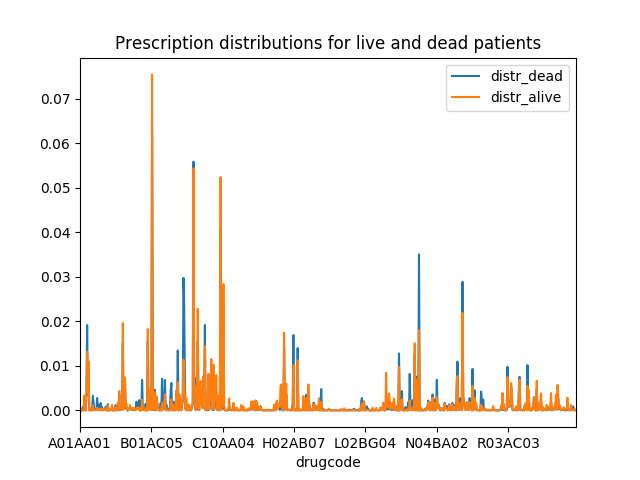

In [37]:
%%python
plt.clf()
combined_to_plot= combined
ax=None
ax = combined_to_plot.plot(ax=ax,x="drugcode",y="distr_dead")
ax = combined_to_plot.plot(ax=ax, x="drugcode",y="distr_alive")
plt.title("Prescription distributions for live and dead patients")

retval = plotfig_magic()

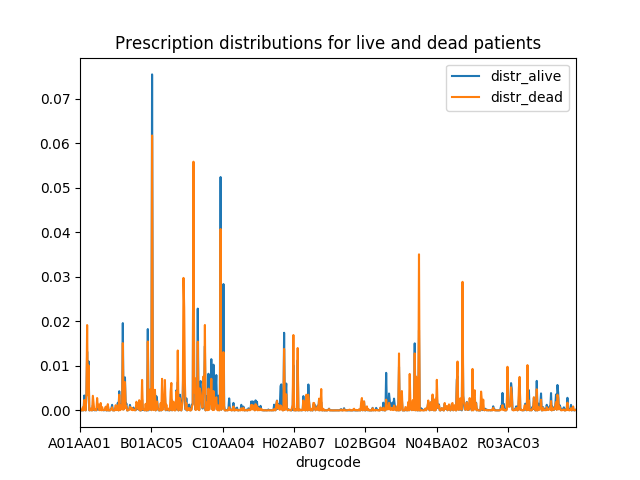

In [38]:
%%python
plt.clf()
ax=None
ax = combined_to_plot.plot(ax=ax, x="drugcode",y="distr_alive")
ax = combined_to_plot.plot(ax=ax,x="drugcode",y="distr_dead")

plt.title("Prescription distributions for live and dead patients")
retval = plotfig_magic()

## How are is the relative difference of prescriptions? (live/dead)

696


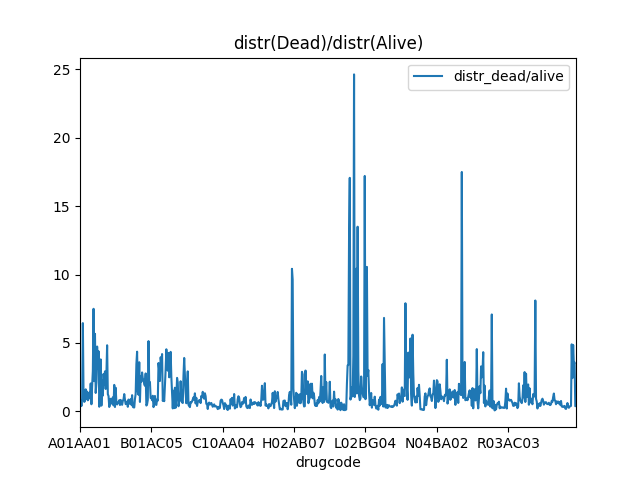

In [39]:
%%python
plt.clf()
print(combined_to_plot.shape[0])
ax=combined_to_plot.plot(x="drugcode",y="distr_dead/alive")
plt.title("distr(Dead)/distr(Alive)")
retval=plotfig_magic()

## a Y-axis Log-plot of the same data makes more sense
* this is since the value range (1, ->) is compressed and the range (0,1) is expanded so that they mirror each other  


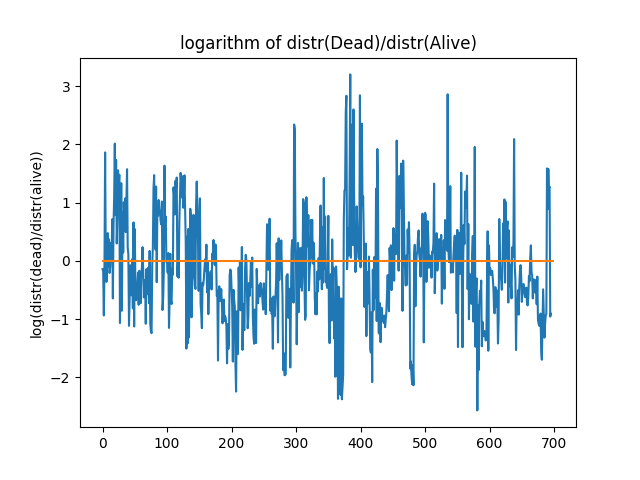

In [40]:
%%python
plt.clf()
fig = plt.figure()
c2p = combined_to_plot
#plot the balance
plt.title("logarithm of distr(Dead)/distr(Alive)")
plt.plot(c2p.index.values,np.log(c2p["distr_dead/alive"].values))
#plot a zero line
plt.plot(np.arange(0,700,step=1),np.zeros(700))
plt.ylabel("log(distr(dead)/distr(alive))")
retval=plotfig_magic()
#print(c2p.index.values)
#print(np.log(c2p["distr_dead/alive"].values))

# NOTE
### Possible exploration 
Some drugs in the 350-420 range differ heavily between patients who live and patients who die, it may be nice to have a deeper look into these
* Note many of said drugs are Cancer medication, for example L01CA04, vinorelbine, which is used to treat lung cancer, for example.

In [41]:
%%python 
#print(c2p[["drugcode","distr_dead/alive"]][350:410])
log_relative = np.log(c2p["distr_dead/alive"])

log_rel_with_drugcodes = pd.concat([c2p["drugcode"], log_relative],axis=1,keys=["drugcode", "log_relative"])


print(log_rel_with_drugcodes[380:395])

    drugcode  log_relative
380  L01BB02      0.167892
381  L01BB05      0.558771
382  L01BC02      0.094134
383  L01BC06      1.401250
384  L01CA04      3.203475
385  L01XE01      0.055256
386  L01XE02      1.537824
387  L01XE04      2.343966
388  L01XE06      0.274337
389  L01XE11      2.602196
390  L01XE18      1.091688
391  L01XX05      0.141264
392  L01XX25     -0.189475
393  L01XX35     -0.063979
394  L02AE02      0.937409


##### Note on how the log curve changes the range of values

In [42]:
%%python 
print(np.log(0.5))
print(np.log(2))

-0.6931471805599453
0.6931471805599453


## Get all prescriptions that occur a short period prior to patients death

In [ ]:
val twoDead=men_dead//.limit(100000)

twoDead.show(2)
prescriptions.show(2)
val test_dead_prescriptions = prescriptions.joinWith(twoDead, prescriptions("id")===twoDead("id"))
    .select("_1.*", "_2.death_timestamp")
    .where("timestamp is not null")
    .select("id", "birthyear","gender","drugcode","timestamp","death_timestamp")
println(test_dead_prescriptions.count)

## Select prescriptions that occured within ~180 days of the patient's death

* Convert the format of year_of_death and month_of_death to unix timestamp, it is simpler to process

### We need some UDFs for this computation
#### In new iteration this is already done in preprocessing

In [44]:
%run "src/scala/udf_hospitalization.scala"

In [49]:
val parse_death_timestamp = (df: DataFrame) => df.withColumn("death_timestamp", 
                unix_timestamp(timestamp_from_year_and_month(
                    $"year_of_death"
                    ,$"month_of_death"
                ), "yyyyMM").cast(TimestampType)
               ).drop("year_of_death").drop("month_of_death")

val timestamp_from_year_and_month = udf {
        (year:Integer, month:Integer) => month.toString.length match {
            case 1 => year.toString+"0"+month.toString
            case 2 => year.toString+month.toString
        }
    }

val prescriptions_close_to_deathtime = test_dead_prescriptions
    .withColumn("diff_pres_death", datediff( col("death_timestamp"),col("timestamp")))
    .where(col("diff_pres_death").leq(180))



val pcdt_with_count = prescriptions_close_to_deathtime.select("drugcode").groupBy("drugcode").count

pcdt_with_count.sort(asc("drugcode")).createOrReplaceTempView("pres_within_180_days_of_death")

parse_death_timestamp: org.apache.spark.sql.DataFrame => org.apache.spark.sql.DataFrame = <function1>
timestamp_from_year_and_month: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function2>,StringType,Some(List(IntegerType, IntegerType)))
prescriptions_close_to_deathtime: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [id: string, birthyear: int ... 5 more fields]
pcdt_with_count: org.apache.spark.sql.DataFrame = [drugcode: string, count: bigint]


In [50]:
pcdt_with_count.sort(desc("count")).show(10)
println(prescriptions_close_to_deathtime.count)

+--------+-----+
|drugcode|count|
+--------+-----+
| B01AC06|17833|
| C07AB02|16678|
| N02BE01|14408|
| C10AA01|10285|
| C03CA01|10059|
| N05CF01| 9798|
| C03CA02| 7991|
| A02BC02| 7023|
| H02AB06| 6377|
| C09AA05| 6172|
+--------+-----+
only showing top 10 rows

322127


In [51]:
prescriptions.select("drugcode").groupBy("drugcode").count.sort(desc("count")).show(10)

+--------+-------+
|drugcode|  count|
+--------+-------+
| B01AC06|3568020|
| C07AB02|2958579|
| C10AA01|2493917|
| N02BE01|2035383|
| N05CF01|1995891|
| H03AA01|1599778|
| C03CA01|1151623|
| C10AA05|1137249|
| C08CA01|1080852|
| N02AJ06| 996290|
+--------+-------+
only showing top 10 rows



# How do the prescription patterns of dead patients differ from 'normal' prescription patterns?

In [52]:
%%python
pres_prior_death_180 = spark.sql("select * from pres_within_180_days_of_death").where("count>20").toPandas()
pres_prior_death_180["distr_180_before_death"]=pres_prior_death_180["count"]/pres_prior_death_180["count"].sum()

In [53]:
%%python
df_to_merge = pres_prior_death_180[["drugcode", "distr_180_before_death"]]

In [54]:
%%python
with_near_death = c2p.merge(df_to_merge, on="drugcode",how="inner")
print(with_near_death[:5])

  drugcode  count_a  count_d  distr_alive  distr_dead  distr_dead/alive  distr_180_before_death
0  A01AA01     8571     3476     0.000529    0.000460          0.869951                0.000522
1  A02AC01     1746     5252     0.000108    0.000696          6.452485                0.000431
2  A02BA02    54269    17668     0.003351    0.002340          0.698364                0.001969
3  A02BA03     2606      952     0.000161    0.000126          0.783626                0.000088
4  A02BC01    60904    25658     0.003761    0.003399          0.903698                0.003435


In [55]:
%%python
print(with_near_death["distr_alive"].sum())
print(with_near_death["distr_dead"].sum())
print(with_near_death["distr_180_before_death"].sum())

0.9834865542032851
0.9918079160031892
0.9981307184230516


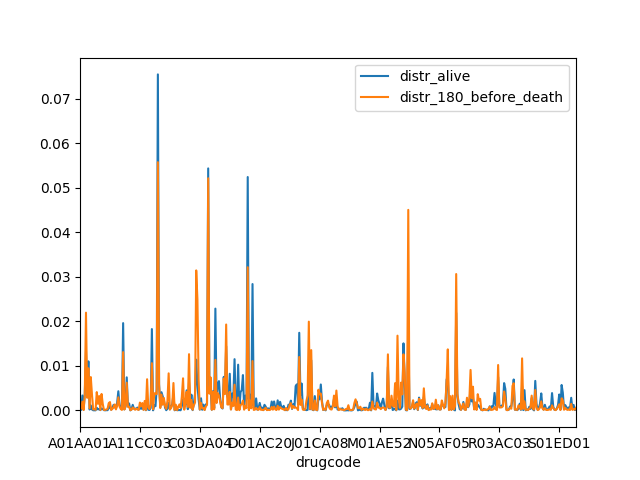

In [56]:
%%python
plt.clf()

ax = None
ax = with_near_death.plot(ax=ax, x="drugcode",y="distr_alive")

ax = with_near_death.plot(ax=ax, x="drugcode",y="distr_180_before_death")

retval = plotfig_magic()

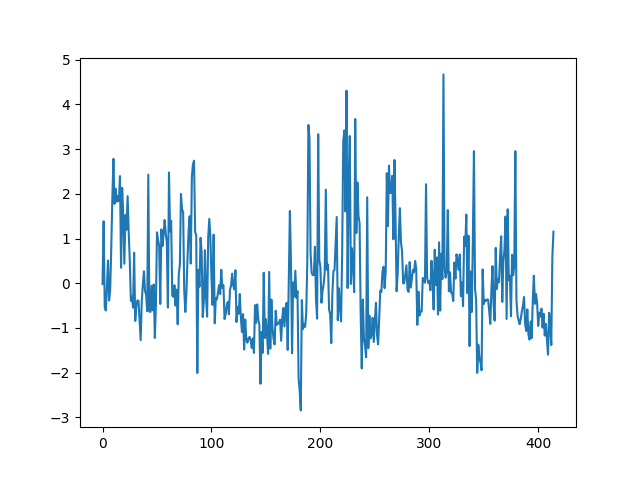

In [58]:
%%python
plt.clf()

ax = None

#ax = with_near_death.plot(ax=ax, x="drugcode",y="distr_180_before_death")
#ax = with_near_death.plot(ax=ax, x="drugcode",y="distr_alive")
ax = plt.plot(np.log(with_near_death["distr_180_before_death"]/with_near_death["distr_alive"]))

retval = plotfig_magic()

### The distribution doesn't immediately look different from the set of all prescriptions from dead patients
### Which drugs are prescribed more often in the ~180 day period prior to death than in the population that is alive?

In [44]:
%%python 
#print(with_near_death[:10])
df_180_rel_alive = with_near_death
df_180_rel_alive["180_rel_alive"]=with_near_death["distr_180_before_death"]/with_near_death["distr_alive"]
df_180_rel_alive=df_180_rel_alive[["drugcode","180_rel_alive"]]
print("dead>alive")
print(df_180_rel_alive.sort_values(by="180_rel_alive", ascending=False)[:20])
print()
print("alive>dead")
print(df_180_rel_alive.sort_values(by="180_rel_alive", ascending=True)[:20])

dead>alive
    drugcode  180_rel_alive
313  N05CD08     106.904043
224  L01CA04      74.335855
232  L02BB04      39.396659
189  H02AB02      34.497791
222  L01AX03      30.546628
198  J01CA01      28.021856
227  L01XE11      26.942970
190  H02AB04      25.609236
221  L01AA07      23.821236
341  N07XX02      19.195400
379  R06AE03      19.189329
10   A04AA01      16.160551
268  N02AB03      15.761105
84   B05XA31      15.516722
83   B05BB01      14.321470
263  N02AA01      13.922671
61   B01AB01      11.910618
261  M05BX04      11.739422
42   A10BD10      11.354047
266  N02AA55      11.059759

alive>dead
    drugcode  180_rel_alive
182  G04BE09       0.058233
181  G04BE08       0.090301
145  C10AA07       0.105780
180  G04BE03       0.119059
87   C01BC04       0.134426
344  R01AD05       0.134920
348  R01BA01       0.142911
238  L04AB01       0.149045
347  R01AD12       0.169837
346  R01AD09       0.189630
242  L04AX03       0.191060
409  S01GX09       0.202421
152  D01BA02       0.2064

In [45]:
spark.sql("show tables").show(false)

+--------+-----------------------------+-----------+
|database|tableName                    |isTemporary|
+--------+-----------------------------+-----------+
|        |elders                       |true       |
|        |elders_drugs                 |true       |
|        |elders_patients              |true       |
|        |elders_prescriptions         |true       |
|        |men_a_drug_c                 |true       |
|        |men_d_drug_c                 |true       |
|        |npr_elders                   |true       |
|        |pres_within_180_days_of_death|true       |
|        |prescription_drugs           |true       |
|        |prescription_patients        |true       |
|        |prescription_prescriptions   |true       |
+--------+-----------------------------+-----------+

